esm encodings

# Host-Phage Interaction Prediction: Reproduction of Research Results
This notebook reproduces the main results of the referenced research paper on host-phage interaction prediction. It covers data loading, preprocessing, feature engineering, model training, evaluation, and result visualization.

## 1. Data Loading
We begin by loading the interaction matrix, phage features, and bacteria (host) features from the provided CSV files.


In [4]:
import numpy as np
import pandas as pd

# Define data paths
host_path = 'data/genomics/bacteria/picard_collection.csv'
phage_path = 'data/genomics/phages/guelin_collection.csv'
embeddings_path = 'data/genomics/bacteria/umap_phylogeny/coli_umap_8_dims.tsv'
interaction_path = 'data/interactions/interaction_matrix.csv'

# Load data
hosts_df = pd.read_csv(host_path, index_col=0, sep=';')
phages_df = pd.read_csv(phage_path, index_col=0, sep=';')
embeddings_df = pd.read_csv(embeddings_path, index_col=0, sep='\t')
interactions_df = pd.read_csv(interaction_path, index_col=0, sep=';')

print(f"       Hosts: {hosts_df.shape}")
print(f"      Phages: {phages_df.shape}")
print(f"  Embeddings: {embeddings_df.shape}")
print(f"Interactions: {interactions_df.shape}")
display(hosts_df.head())
display(phages_df.head())
display(embeddings_df.head())
display(interactions_df.head())

       Hosts: (403, 20)
      Phages: (96, 10)
  Embeddings: (404, 8)
Interactions: (402, 96)


,Gembase,Host,Origin,Pathotype,Clermont_Phylo,ST_Warwick,O-type,H-type,Mouse_killed_10,Capsule_ABC,Capsule_GroupIV_e,Capsule_GroupIV_e_stricte,Capsule_GroupIV_s,Capsule_Wzy_stricte,LPS_type,Collection,Klebs_capsule_type,n_defense_systems,n_infections,ABC_serotype
bacteria,,,,,,,,,,,,,,,,,,,,
001-023,ESCO.0622.00103,Human,Faeces,Commensal,G,1163,O149,H23,0.0,0.0,0.0,1.0,1.0,1.0,R4,Original,NaN,9.0,32,NaN
001-031-c1,ESCO.0622.00308,Human,Faeces,Commensal,B2,452,O81,H27,0.0,1.0,0.0,0.0,1.0,1.0,R3,Original,NaN,8.0,5,Unknown
003-026,ESCO.0622.00119,Human,Faeces,Commensal,G,1163,O33,H23,0.0,0.0,0.0,1.0,1.0,1.0,R4,Original,NaN,6.0,28,NaN
013-008,ESCO.0622.00326,Human,Faeces,Commensal,B2,452,O81,H27,0.0,1.0,0.0,0.0,1.0,1.0,R3,Original,NaN,6.0,5,Unknown
025-010,ESCO.0622.00213,Human,Faeces,Commensal,E,543,O169,H9,0.0,0.0,0.0,1.0,1.0,0.0,R4,Original,NaN,10.0,30,NaN


,Morphotype,Family,Genus,Species,Genome_size,Phage_host,Phage_host_phylo,Old_Family,Subfamily,Old_Genus
phage,,,,,,,,,,
409_P1,Podoviridae,Autographiviridae,Kayfunavirus,Kayfunavirus ZG49,40079,PDP21,D,Autographiviridae,Studiervirinae,Kayfunavirus
409_P3,Podoviridae,Autographiviridae,Vectrevirus,Vectrevirus VEc3,45588,PDP21,D,Autographiviridae,Molineuxvirinae,Vectrevirus
409_P5,Podoviridae,Autographiviridae,Vectrevirus,Vectrevirus VEc3,45588,PDP21,D,Autographiviridae,Molineuxvirinae,Vectrevirus
409_P6,Podoviridae,Autographiviridae,Vectrevirus,Vectrevirus VEc3,44789,PDP21,D,Autographiviridae,Molineuxvirinae,Vectrevirus
409_P8,Siphoviridae,Other,Kagunavirus,Kagunavirus K1G,43594,PDP21,D,Siphoviridae,Guernseyvirinae,Kagunavirus


,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7
bacteria,,,,,,,,
ECOR-12,14.809212,4.479959,6.614325,7.403806,5.942172,6.080655,4.733537,5.059260
IAI14,14.923162,4.349688,6.830584,7.355976,5.845553,6.122035,4.627062,4.886468
ECOR-25,14.655961,4.416495,6.713003,7.468843,5.975815,6.118094,4.856316,5.061173
IAI19,14.602400,4.480703,6.806061,7.532146,5.790100,6.129730,4.641324,5.032660
IAI20,14.739294,4.473202,6.754572,7.448086,5.855868,6.016634,4.707124,4.993468


,55989_P2,LF82_P8,AL505_Ev3,LF73_P4,BCH953_P2,BCH953_P4,BCH953_P5,LF73_P1,LF73_P3,NIC06_P2,...,LM08_P2,NRG_12A1B,411_P1,536_P12,BDX09_P1,411_P2,LF50_P3,LM40_P1,LM40_P2,LM40_P3
bacteria,,,,,,,,,,,,,,,,,,,,,
ECOR-54,0.0,1.0,0.0,1.0,1.0,0.0,0.0,4.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DIJ06,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ECOR-52,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ECOR-51,3.0,2.0,2.0,3.0,3.0,4.0,4.0,3.0,3.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
ECOR-55,2.0,3.0,1.0,4.0,0.0,2.0,1.0,3.0,4.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## 2. Data Preprocessing
We preprocess the data by aligning indices, handling missing values, and ensuring all datasets are compatible for merging and modeling.

In [5]:
# Handle missing values
hosts_df = hosts_df.fillna(hosts_df.median(numeric_only=True))
phages_df = phages_df.fillna(phages_df.median(numeric_only=True))

for df in [phages_df, hosts_df]:
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna('Other')

interactions_df = interactions_df.dropna(axis=0, how='any')
interactions_df = interactions_df.dropna(axis=1, how='any')

# Convert categorical columns to 'category' dtype
for df in [phages_df, hosts_df]:
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

print(f"Filtered Interactions: {interactions_df.shape}")

Filtered Interactions: (387, 96)


## 3. Feature Engineering
We construct the feature matrix for each host-phage pair by concatenating phage and host features. The target is the interaction (1/0) from the matrix.

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

FEATURE_MIN_ROWS = 5  # minimum number of rows required per categorical feature
INCLUDED_HOST_FEATURES = ('ST_Warwick', 'O-type', 'H-type')

# Convert interaction matrix to binary (1 = any interaction, 0 = no interaction)
interactions_df = (interactions_df > 0).astype(int)

# Add embeddings to the hosts
hosts_df = pd.merge(embeddings_df, hosts_df, left_index=True, right_index=True)

# Reduce feature complexity by recoding rare categories.
for feature in ('O-type', 'ST_Warwick'):
    to_recode = hosts_df.groupby(feature, observed=False).filter(lambda rows: len(rows) < FEATURE_MIN_ROWS)[feature].unique()
    if 'Other' not in hosts_df[feature].cat.categories:
        hosts_df[feature] = hosts_df[feature].cat.add_categories(['Other'])
    hosts_df.loc[hosts_df[feature].isin(to_recode), feature] = 'Other'

# Add data of their respective host to the phages; and remove some features
if 'Phage_host' in phages_df.columns:
    phages_df = pd.merge(
        phages_df,
        hosts_df.filter(regex=rf"({'|'.join(INCLUDED_HOST_FEATURES)})", axis=1),
        left_on="Phage_host",
        right_on="bacteria",
        right_index=True,
    ).rename({feature: f"{feature}_host" for feature in INCLUDED_HOST_FEATURES}, axis=1)
phages_df = phages_df.filter(regex=r"(Morphotype|Genus|Phage_host)")
hosts_df = hosts_df.filter(regex=r"(UMAP|O-type|LPS|ST_Warwick|Klebs|ABC_serotype)")

# Align indices and filter to common phages/hosts
common_hosts = interactions_df.index.intersection(hosts_df.index)
common_phages = interactions_df.columns.intersection(phages_df.index)

hosts_df = hosts_df.loc[common_hosts.tolist()]
phages_df = phages_df.loc[common_phages.tolist()]
interactions_df = interactions_df.loc[common_hosts.tolist(), common_phages.tolist()]

# Build feature matrix and target vector
X = []
y = []
phage_ids = []
host_ids = []

for host in interactions_df.index:
    for phage in interactions_df.columns:
        X.append(np.concatenate([hosts_df.loc[host], phages_df.loc[phage]]))
        y.append(interactions_df.loc[host, phage])
        phage_ids.append(phage)
        host_ids.append(host)

X, y = np.array(X), np.array(y)

# Encode categorical features and scale numeric ones
categorical_indices = [i for i, v in enumerate(X[0]) if isinstance(v, str)]
numeric_indices = [i for i in range(len(X[0])) if i not in categorical_indices]

encoder = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_indices),
        ('cat', OneHotEncoder(sparse_output=False), categorical_indices),
    ]
)
X = encoder.fit_transform(X)

# Split the data into training and testing sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Feature matrix shape: {X.shape}")
print(f" Target vector shape: {y.shape}")

Feature matrix shape: (28483, 162)
 Target vector shape: (28483,)


## 4. Model Training and Cross-Validation
We train a Random Forest classifier and evaluate it using stratified 5-fold cross-validation. We also compare with a Logistic Regression and a DummyClassifier (baseline).

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm

# Metrics, class weights, and models
metrics = ('accuracy', 'f1', 'roc_auc')
perc_pos_class = np.sum(y) / len(y)
if 0.60 <= perc_pos_class:
    cw = {0: 1, 1: 0.8}
elif 0.4 <= perc_pos_class < 0.6:
    cw = {0: 1, 1: 1}
elif 0.3 <= perc_pos_class < 0.4:
    cw = {0: 1, 1: 1.5}
elif 0.2 <= perc_pos_class < 0.3:
    cw = {0: 1, 1: 2}
else:
    cw = {0: 1, 1: 3}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression L1': LogisticRegression(penalty='l1', solver='saga', max_iter=10_000, class_weight=cw, random_state=42),
    'Logistic Regression L2': LogisticRegression(max_iter=10_000, class_weight=cw, random_state=42),
    'Random Forest D3': RandomForestClassifier(n_estimators=250, max_depth=3, class_weight=cw, random_state=42),
    'Random Forest D6': RandomForestClassifier(n_estimators=250, max_depth=6, class_weight=cw, random_state=42),
}

# Training and Evaluation (cross-validation)
results = []
for name, model in tqdm(models.items(), desc="Training and Evaluation", unit='model(s)'):
    scores = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=metrics,
        return_train_score=True,
        return_estimator=True,
    )
    for fold in range(len(list(scores.values())[0])):
        results.append({
            'model_name': name,
            'fold': fold + 1,
            **{k.replace('test_', 'val_'): v[fold] for k, v in scores.items()},
        })
        for metric in metrics:
            match metric:
                case 'accuracy':
                    results[-1][f'test_{metric}'] = accuracy_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'f1':
                    results[-1][f'test_{metric}'] = f1_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'roc_auc':
                    results[-1][f'test_{metric}'] = roc_auc_score(y_test, scores['estimator'][fold].predict(X_test))
                case _:
                    raise RuntimeError('Unknown metric specified')
results_df = pd.DataFrame(results).set_index(['model_name', 'fold'])

for i, (name, row) in enumerate(results_df.drop(columns=['estimator']).groupby('model_name').agg(['mean', 'std']).iterrows()):
    if i != 0:
        print()
    print(f"{name} Model Scores:")
    for metric in metrics:
        print(f"  Training {metric.replace('_', ' ').upper():>8} Score: {row[f'train_{metric}']['mean']:.03f}±{row[f'train_{metric}']['std']:.03f}", end='  ')
        print(f"  Validation {metric.replace('_', ' ').upper():>8} Score: {row[f'val_{metric}']['mean']:.03f}±{row[f'val_{metric}']['std']:.03f}", end='  ')
        print(f"  Testing {metric.replace('_', ' ').upper():>8} Score: {row[f'test_{metric}']['mean']:.03f}±{row[f'test_{metric}']['std']:.03f}")

Training and Evaluation:   0%|          | 0/5 [00:00<?, ?model(s)/s]

Dummy Model Scores:
  Training ACCURACY Score: 0.799±0.000    Validation ACCURACY Score: 0.799±0.000    Testing ACCURACY Score: 0.801±0.000
  Training       F1 Score: 0.000±0.000    Validation       F1 Score: 0.000±0.000    Testing       F1 Score: 0.000±0.000
  Training  ROC AUC Score: 0.500±0.000    Validation  ROC AUC Score: 0.500±0.000    Testing  ROC AUC Score: 0.500±0.000

Logistic Regression L1 Model Scores:
  Training ACCURACY Score: 0.812±0.001    Validation ACCURACY Score: 0.809±0.003    Testing ACCURACY Score: 0.824±0.002
  Training       F1 Score: 0.552±0.002    Validation       F1 Score: 0.545±0.007    Testing       F1 Score: 0.576±0.004
  Training  ROC AUC Score: 0.840±0.001    Validation  ROC AUC Score: 0.834±0.002    Testing  ROC AUC Score: 0.741±0.002

Logistic Regression L2 Model Scores:
  Training ACCURACY Score: 0.812±0.002    Validation ACCURACY Score: 0.809±0.003    Testing ACCURACY Score: 0.824±0.001
  Training       F1 Score: 0.551±0.003    Validation       F1 Sc

## 5. Feature Importance (Random Forest)
We examine the most important features as determined by the Random Forest model.

In [8]:
# Fit Random Forest on all data for feature importances
importances = results_df.loc["Random Forest D6"]["estimator"].iloc[0].feature_importances_
feature_names = encoder.get_feature_names_out()

# Top 10 features
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False).head(10)
display(importances_df)

,feature,importance
84,cat__x13_Myoviridae,0.171199
85,cat__x13_Podoviridae,0.070178
86,cat__x13_Siphoviridae,0.042556
122,cat__x15_LF82,0.041841
3,num__x3,0.036619
82,cat__x12_Other,0.035293
89,cat__x14_Felixounavirus,0.032231
154,cat__x17_Phapecoctavirus,0.030720
73,cat__x12_K1,0.030719
147,cat__x17_Felixounavirus,0.027840


## 6. Visualization of Results
We visualize model performance and feature importances.

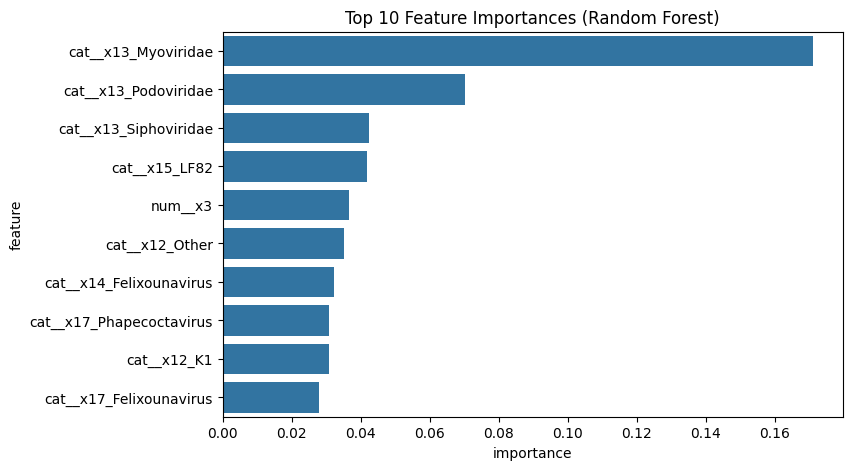

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances
plt.figure(figsize=(8, 5))
graph = sns.barplot(x='importance', y='feature', data=importances_df)
graph.set_title('Top 10 Feature Importances (Random Forest)')#
plt.show()

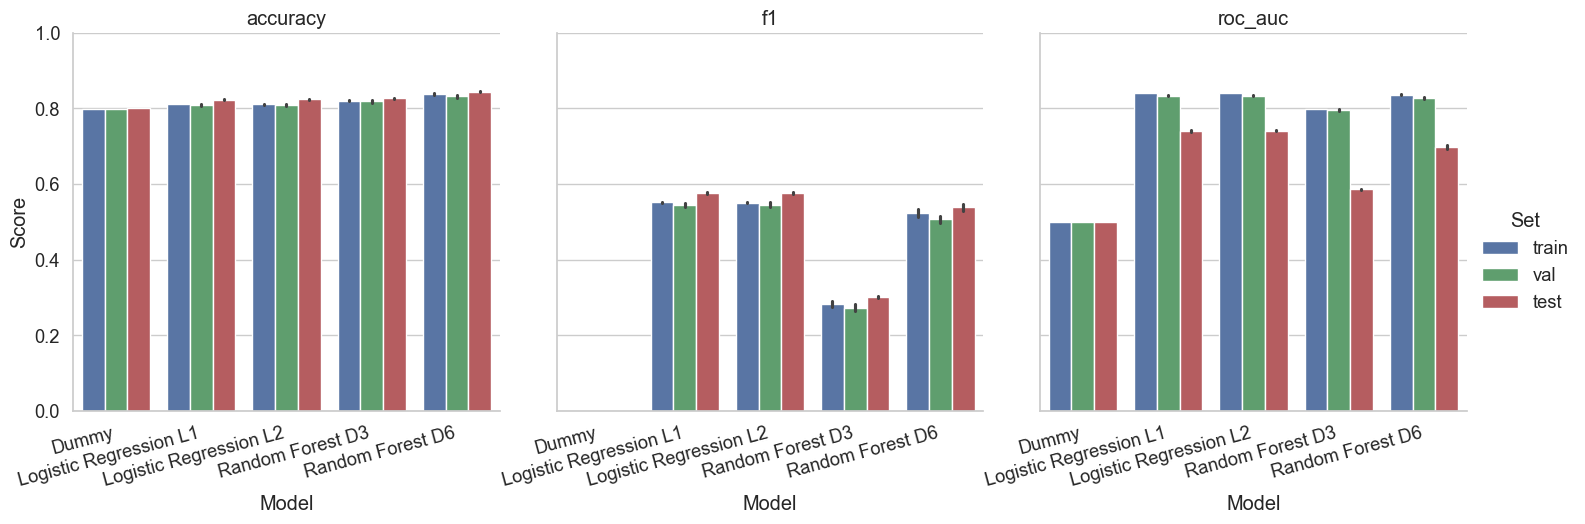

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = pd.melt(
    results_df.reset_index(),
    id_vars=('model_name',),
    value_vars=[column for column in results_df.columns if column.startswith(('train_', 'val_', 'test_'))],
    var_name='set_metric',
    value_name='score'
)
plot_df['set'] = pd.Categorical(plot_df['set_metric'].str.extract(r'^(train|val|test)_')[0], categories=('train', 'val', 'test'), ordered=True)
plot_df['metric'] = plot_df['set_metric'].str.extract(rf'_({"|".join(metrics)})$').astype('category')
plot_df = plot_df.drop(columns=['set_metric'])

# Improve plot style for presentation
sns.set_theme(style="whitegrid", font_scale=1.2)
palette = {"train": "#4C72B0", "val": "#55A868", "test": "#C44E52"}

graph = sns.catplot(
    data=plot_df,
    kind='bar',
    x='model_name',
    y='score',
    hue='set',
    col='metric',
    palette=palette,
)

graph.set_titles('{col_name}').set_axis_labels('Model', 'Score').set_xticklabels(rotation=15, horizontalalignment='right')
for ax in graph.axes[0]:
    ax.set_ylim(0, 1)
graph._legend.set_title("Set")
plt.show()

/var/folders/cz/4k6wq6y95zv1bmpp7n889ttr0000gn/T/ipykernel_28186/430299010.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


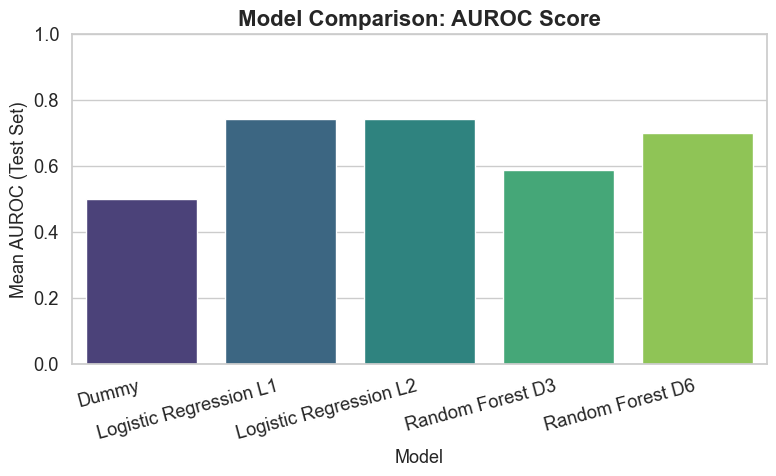

In [12]:
# Plot AUROC scores for each model (presentation style)
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid", font_scale=1.2)

auroc_means = results_df.groupby('model_name')['test_roc_auc'].mean().reset_index()
auroc_stds = results_df.groupby('model_name')['test_roc_auc'].std().reset_index()
auroc_means = auroc_means.merge(auroc_stds, on='model_name', suffixes=('_mean', '_std'))

ax = sns.barplot(
    data=auroc_means,
    x='model_name',
    y='test_roc_auc_mean',
    #yerr=auroc_means['test_roc_auc_std'],
    palette='viridis'
)
ax.set_title('Model Comparison: AUROC Score', fontsize=16, weight='bold')
ax.set_xlabel('Model', fontsize=13)
ax.set_ylabel('Mean AUROC (Test Set)', fontsize=13)
ax.set_ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

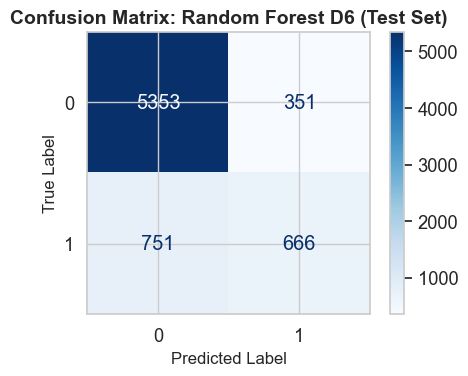

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for the best Random Forest D6 model on the test set
best_rf = results_df.loc["Random Forest D6"]["estimator"].iloc[0]
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(5, 4))
sns.set_theme(style="whitegrid", font_scale=1.2)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix: Random Forest D6 (Test Set)", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

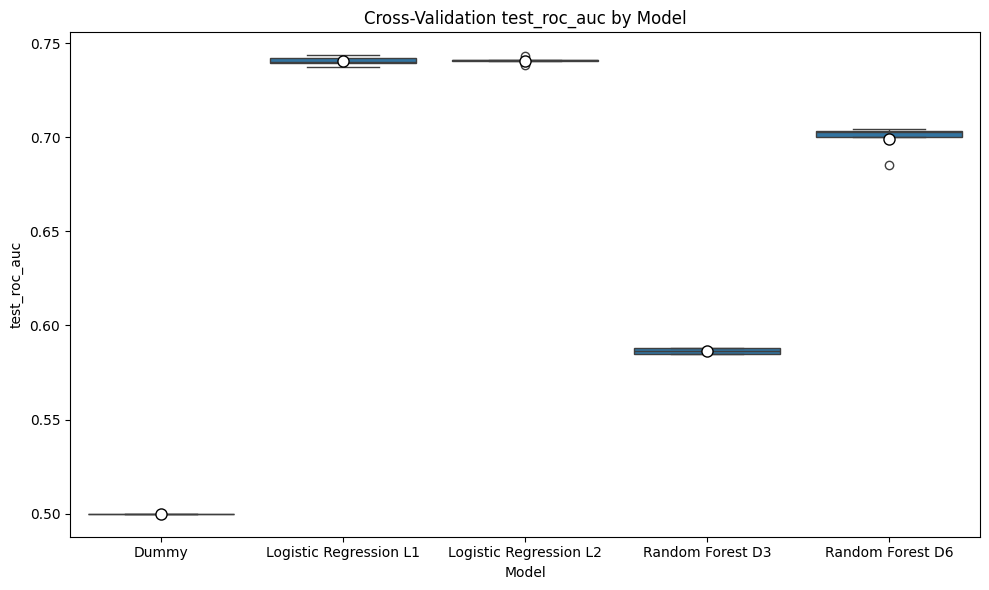

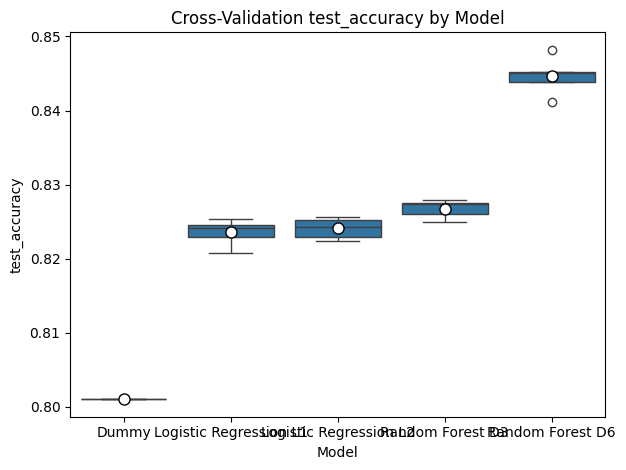

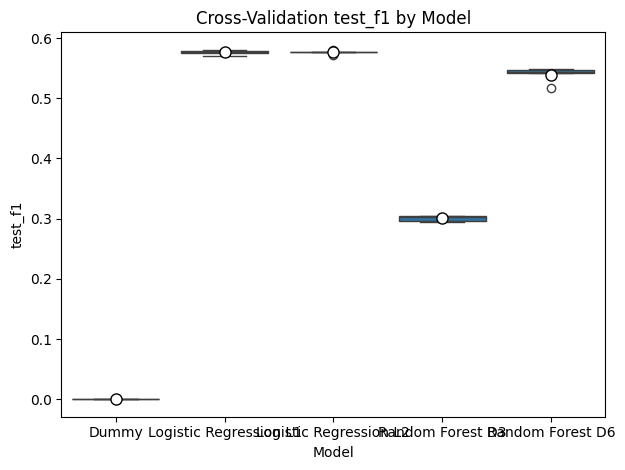

In [12]:
# Visualize test scores for each model and metric
plt.figure(figsize=(10, 6))
score_metrics = ['test_roc_auc', 'test_accuracy', 'test_f1']
sns.boxplot(
    data=results.reset_index(),
    x='model',
    y='value',
    hue='variable',
    palette='Set2',
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"8"}
) if False else None  # placeholder for boxplot, see below

# Plot each metric as a separate boxplot
for metric in score_metrics:
    sns.boxplot(
        data=results_df.reset_index(),
        x='model_name',
        y=metric,
        showmeans=True,
        meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                   "markersize":"8"}
    )
    plt.title(f"Cross-Validation {metric} by Model")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

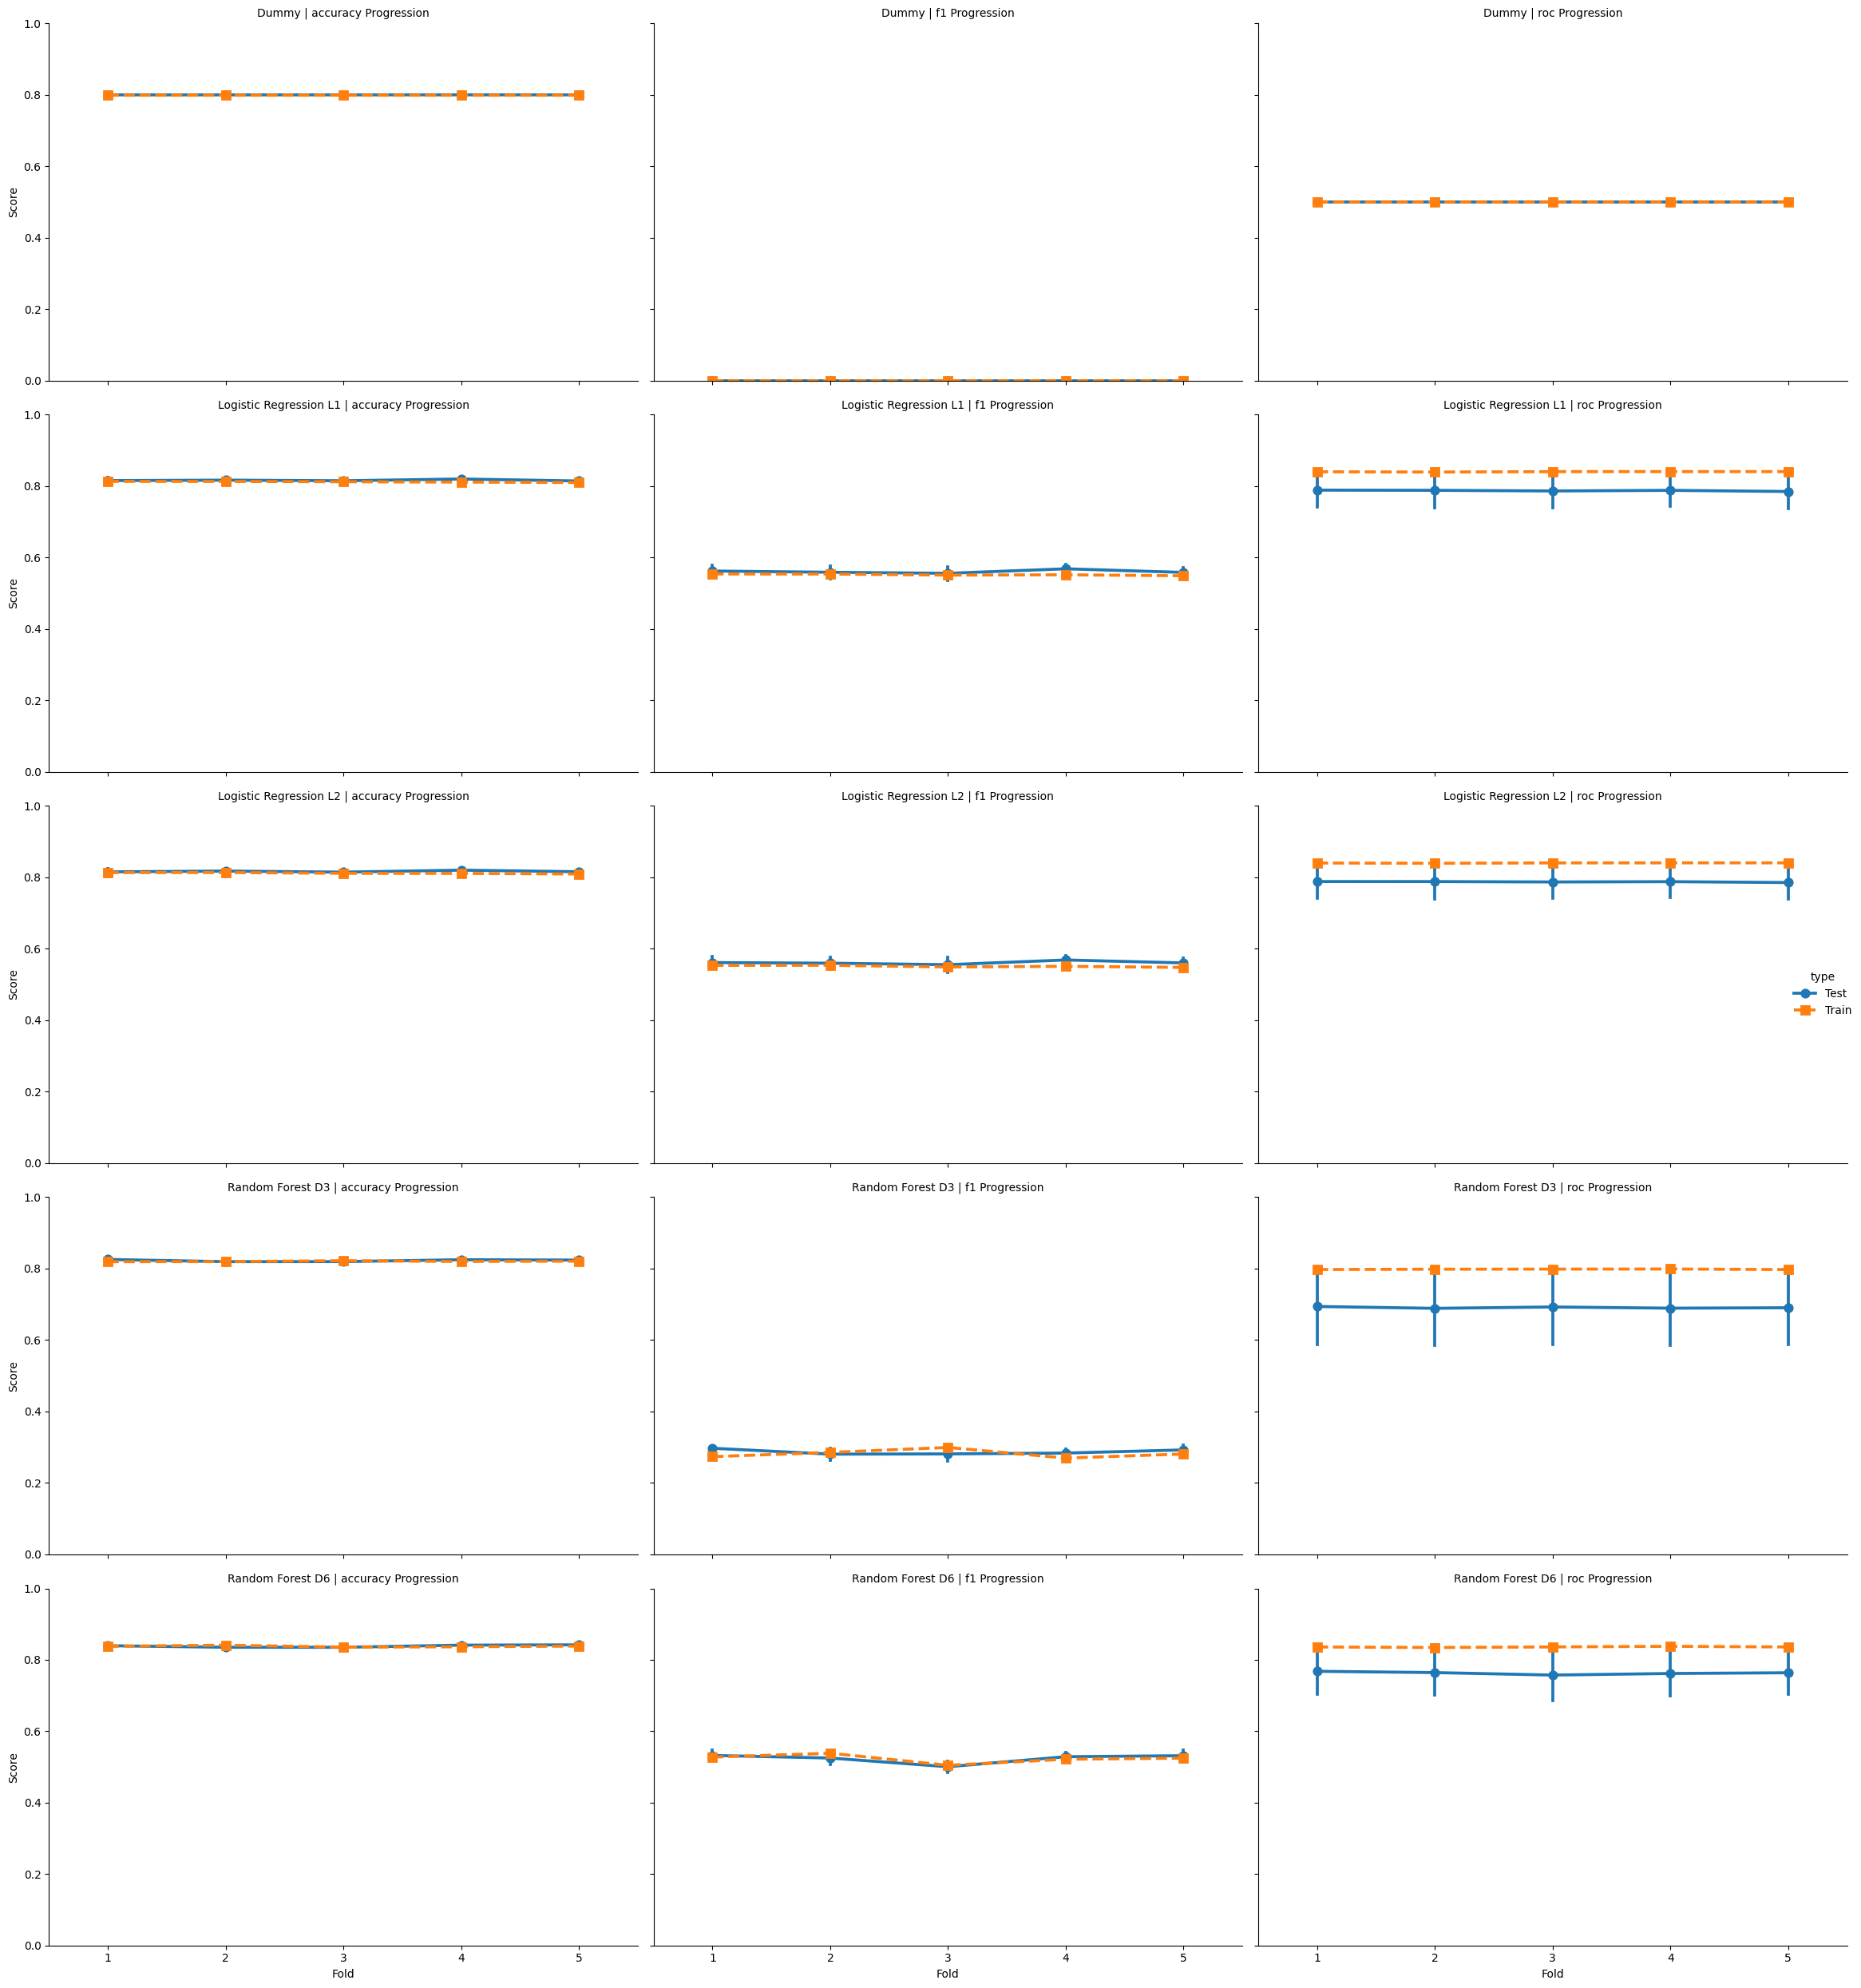

In [49]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame and metrics is a list of metrics
# First, we need to reshape the DataFrame to a long format suitable for Seaborn
long_df = pd.melt(results_df.reset_index(),
                   id_vars=['model_name', 'fold'], 
                   value_vars=[column for column in results_df.columns if column.startswith(('train_', 'val_', 'test_'))],
                   var_name='score_type', 
                   value_name='score')

# Extract metric and type (train/val) from the score_type column
long_df['metric'] = long_df['score_type'].apply(lambda x: x.split('_')[1])
long_df['type'] = long_df['score_type'].apply(lambda x: 'Train' if 'train' in x else 'Test')

# Now we can create the catplot
g = sns.catplot(data=long_df, 
                x='fold', 
                y='score', 
                hue='type', 
                col='metric', 
                row='model_name', 
                kind='point', 
                markers=["o", "s"], 
                linestyles=["-", "--"],
                height=5, 
                aspect=1.5)

# Set titles and labels
g.set_axis_labels("Fold", "Score")
g.set_titles(col_template="{col_name} Progression", row_template="{row_name}")

# Adjust y-axis limits
for ax in g.axes.flatten():
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()